In [13]:
pip install nibabel matplotlib numpy scikit-image imageio torch opencv-python

   ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
   ---------------------------------------- 0.1/39.5 MB 1.6 MB/s eta 0:00:25
   ---------------------------------------- 0.5/39.5 MB 5.9 MB/s eta 0:00:07
   - -------------------------------------- 1.1/39.5 MB 8.5 MB/s eta 0:00:05
   -- ------------------------------------- 2.0/39.5 MB 11.6 MB/s eta 0:00:04
   --- ------------------------------------ 3.2/39.5 MB 14.4 MB/s eta 0:00:03
   ---- ----------------------------------- 4.2/39.5 MB 16.6 MB/s eta 0:00:03
   ----- ---------------------------------- 5.0/39.5 MB 16.9 MB/s eta 0:00:03
   ------ --------------------------------- 6.2/39.5 MB 18.0 MB/s eta 0:00:02
   ------- -------------------------------- 7.4/39.5 MB 18.8 MB/s eta 0:00:02
   -------- ------------------------------- 8.6/39.5 MB 19.5 MB/s eta 0:00:02
   --------- ------------------------------ 9.7/39.5 MB 19.5 MB/s eta 0:00:02
   ----------- ---------------------------- 10.9/39.5 MB 23.4 MB/s eta 0:00

Data shape: (176, 198, 160), Data type: float64


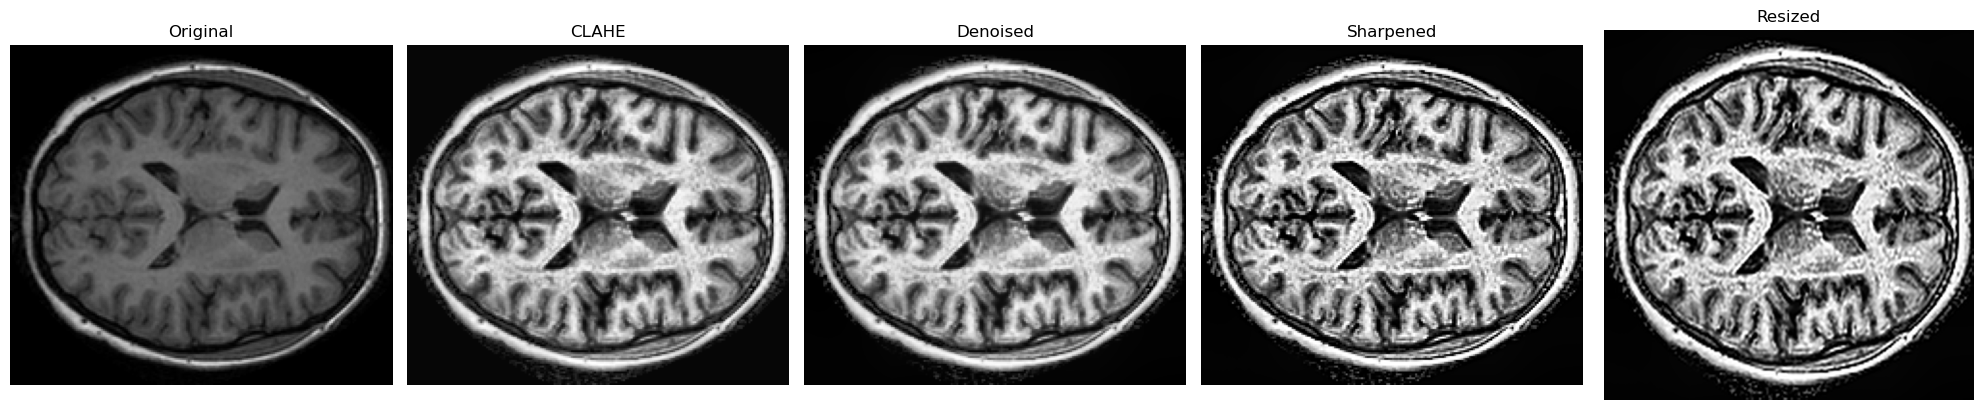

In [2]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from skimage import exposure, transform, restoration, filters

# Load NIfTI file from current directory
img = nib.load('t.nii')
data = np.squeeze(img.get_fdata())
print(f"Data shape: {data.shape}, Data type: {data.dtype}")

# Extract middle slice
slice_index = data.shape[2] // 2
slice_img = data[:, :, slice_index]

# Normalize to [0, 1]
slice_img_norm = (slice_img - np.min(slice_img)) / (np.max(slice_img) - np.min(slice_img))

# Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
clahe_img = exposure.equalize_adapthist(slice_img_norm, clip_limit=0.03)

# Denoise with bilateral filter
denoised_img = restoration.denoise_bilateral(clahe_img, sigma_color=0.05, sigma_spatial=15)

# Sharpen image
sharpened_img = filters.unsharp_mask(denoised_img, radius=1.0, amount=1.5)

# Resize image to 512x512 with cubic interpolation
resized_img = transform.resize(sharpened_img, (512, 512), order=3, anti_aliasing=True)

# Display results
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
titles = ['Original', 'CLAHE', 'Denoised', 'Sharpened', 'Resized']
images = [slice_img_norm, clahe_img, denoised_img, sharpened_img, resized_img]

for i in range(5):
    axs[i].imshow(images[i], cmap='gray')
    axs[i].set_title(titles[i])
    axs[i].axis('off')

plt.tight_layout()
plt.show()


#  The code improves image quality by first normalizing the image intensity to a [0,1] range, then applying CLAHE (Contrast Limited Adaptive Histogram Equalization) to enhance local contrast. Next, it uses bilateral filtering to denoise the image while preserving edges, followed by unsharp masking to sharpen and enhance fine details. Finally, the image is resized with high-quality cubic interpolation to increase resolution and maintain visual clarity. 

Original data shape: (176, 198, 160), data type: float64


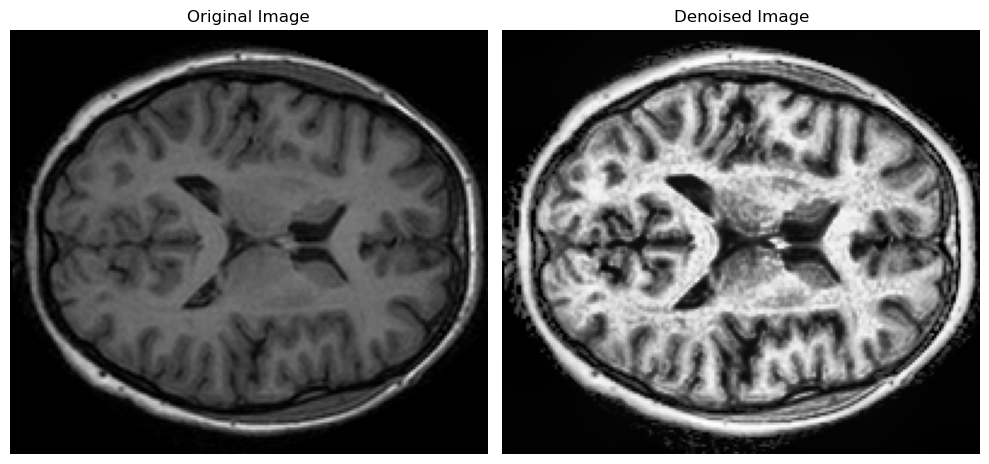

In [3]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from skimage import exposure, transform
from skimage.restoration import denoise_bilateral

# Load the NIfTI file
img = nib.load('t.nii')
data = np.squeeze(img.get_fdata())
print(f"Original data shape: {data.shape}, data type: {data.dtype}")

# Select the middle slice
slice_index = data.shape[2] // 2
slice_img = data[:, :, slice_index]

# Normalize the slice to [0, 1]
slice_img_norm = (slice_img - np.min(slice_img)) / (np.max(slice_img) - np.min(slice_img))

# Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
clahe_img = exposure.equalize_adapthist(slice_img_norm, clip_limit=0.03)

# Denoise using bilateral filter
denoised_img = denoise_bilateral(clahe_img, sigma_color=0.05, sigma_spatial=15)

# Display the original and denoised images
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(slice_img_norm, cmap='gray')
axs[0].set_title('Original Image')
axs[0].axis('off')
axs[1].imshow(denoised_img, cmap='gray')
axs[1].set_title('Denoised Image')
axs[1].axis('off')
plt.tight_layout()
plt.show()


# PixSimWave Algorithm [1]

Akindele, Romoke Grace, Ming Yu, Paul Shekonya Kanda, Eunice Oluwabunmi Owoola, and Ifeoluwapo Aribilola. ‘Denoising of Nifti (MRI) Images with a Regularized Neighborhood Pixel Similarity Wavelet Algorithm’. Sensors 23, no. 18 (January 2023): 7780. https://doi.org/10.3390/s23187780.


Data shape: (176, 198, 160), Data type: float64


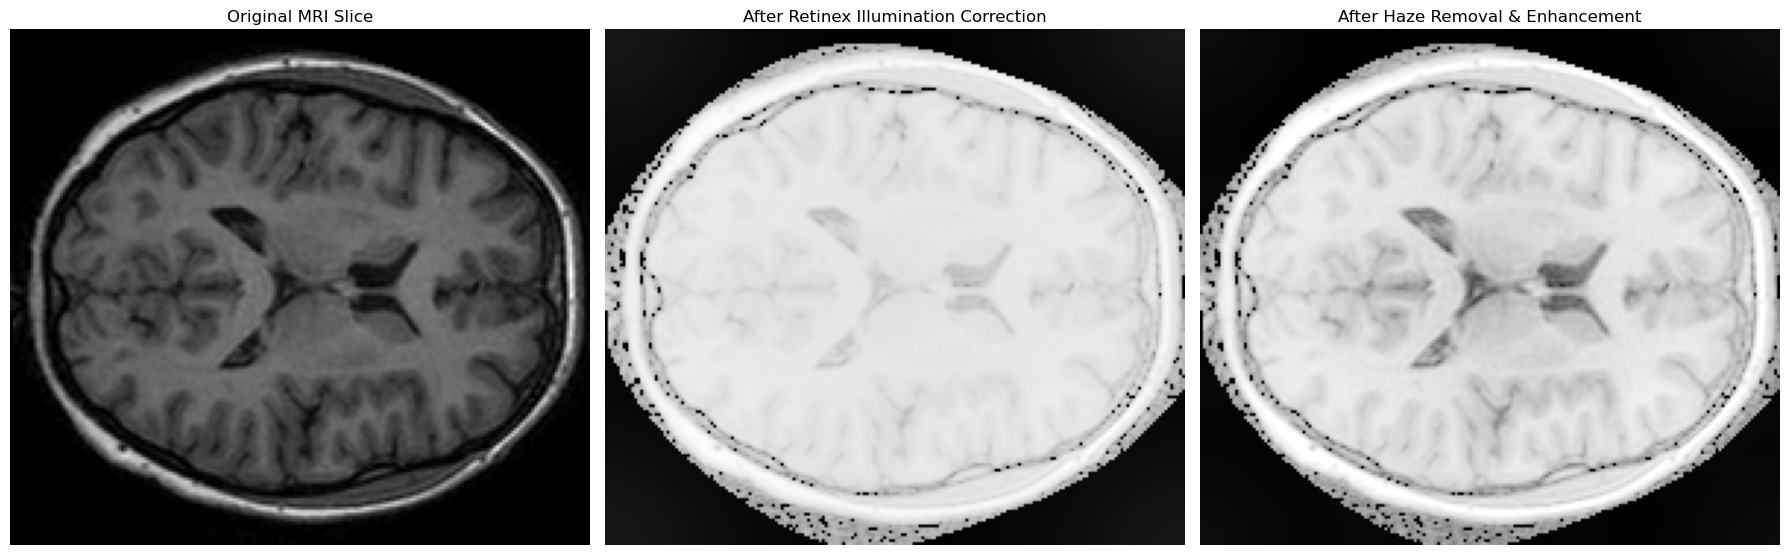

In [14]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import exposure

def single_scale_retinex(img, sigma=30):
    # Convert to float and add a small value to avoid log(0)
    img = img.astype(np.float32) + 1e-6
    retinex = np.log(img) - np.log(cv2.GaussianBlur(img, (0, 0), sigma))
    # Normalize to [0,1]
    retinex = (retinex - np.min(retinex)) / (np.max(retinex) - np.min(retinex))
    return retinex

def dark_channel(im, size=15):
    # Estimate dark channel for haze removal
    b, g, r = cv2.split(im)
    min_img = cv2.min(cv2.min(r, g), b)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (size, size))
    dark_ch = cv2.erode(min_img, kernel)
    return dark_ch

def estimate_atmospheric_light(im, dark_ch, top_percent=0.001):
    # Find top brightest pixels in dark channel to estimate atmospheric light
    flat_img = im.reshape(-1, 3)
    flat_dark = dark_ch.ravel()
    num_pixels = int(max(flat_dark.size * top_percent, 1))
    indices = np.argpartition(flat_dark, -num_pixels)[-num_pixels:]
    atmospheric_light = np.max(flat_img[indices], axis=0)
    return atmospheric_light

def transmission_estimate(im, atmospheric_light, omega=0.95, size=15):
    # Estimate transmission map for haze removal
    norm_img = im / atmospheric_light
    transmission = 1 - omega * dark_channel(norm_img, size)
    return transmission

def guided_filter(I, p, r, eps):
    # Guided filter implementation for transmission refinement
    mean_I = cv2.boxFilter(I, cv2.CV_64F, (r,r))
    mean_p = cv2.boxFilter(p, cv2.CV_64F, (r,r))
    corr_I = cv2.boxFilter(I*I, cv2.CV_64F, (r,r))
    corr_Ip = cv2.boxFilter(I*p, cv2.CV_64F, (r,r))
    var_I = corr_I - mean_I*mean_I
    cov_Ip = corr_Ip - mean_I*mean_p
    a = cov_Ip / (var_I + eps)
    b = mean_p - a*mean_I
    mean_a = cv2.boxFilter(a, cv2.CV_64F, (r,r))
    mean_b = cv2.boxFilter(b, cv2.CV_64F, (r,r))
    q = mean_a*I + mean_b
    return q

def recover_image(im, transmission, atmospheric_light, t0=0.1):
    # Recover the haze-free image
    transmission = np.clip(transmission, t0, 1)
    J = np.empty_like(im)
    for i in range(3):
        J[:, :, i] = (im[:, :, i] - atmospheric_light[i]) / transmission + atmospheric_light[i]
    J = np.clip(J, 0, 1)
    return J

# Load NIfTI file
img = nib.load('t.nii')
data = np.squeeze(img.get_fdata())
print(f"Data shape: {data.shape}, Data type: {data.dtype}")

# Extract middle slice and normalize to [0,1]
slice_index = data.shape[2] // 2
slice_img = data[:, :, slice_index]
slice_norm = (slice_img - np.min(slice_img)) / (np.max(slice_img) - np.min(slice_img))

# Convert grayscale slice to 3-channel image for haze removal (repeat channels)
slice_3ch = np.stack([slice_norm]*3, axis=-1).astype(np.float64)

# Step 1: Apply Single Scale Retinex for illumination correction
retinex_img = single_scale_retinex(slice_3ch, sigma=30)

# Step 2: Estimate dark channel
dark_ch = dark_channel(retinex_img, size=15)

# Step 3: Estimate atmospheric light
A = estimate_atmospheric_light(retinex_img, dark_ch, top_percent=0.001)

# Step 4: Estimate transmission map
transmission = transmission_estimate(retinex_img, A, omega=0.95, size=15)

# Step 5: Refine transmission map using guided filter
gray_retinex = cv2.cvtColor((retinex_img * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY).astype(np.float64) / 255
transmission_refined = guided_filter(gray_retinex, transmission, r=60, eps=1e-3)

# Step 6: Recover haze-free image
dehazed_img = recover_image(retinex_img, transmission_refined, A)

# Convert back to grayscale by averaging channels for visualization
final_img = np.mean(dehazed_img, axis=2)

# Clip to [0,1]
final_img = np.clip(final_img, 0, 1)

# Plotting results
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
axs[0].imshow(slice_norm, cmap='gray')
axs[0].set_title('Original MRI Slice')
axs[0].axis('off')

axs[1].imshow(retinex_img[...,0], cmap='gray')
axs[1].set_title('After Retinex Illumination Correction')
axs[1].axis('off')

axs[2].imshow(final_img, cmap='gray')
axs[2].set_title('After Haze Removal & Enhancement')
axs[2].axis('off')

plt.tight_layout()
plt.show()


Data shape: (176, 198, 160), Data type: float64


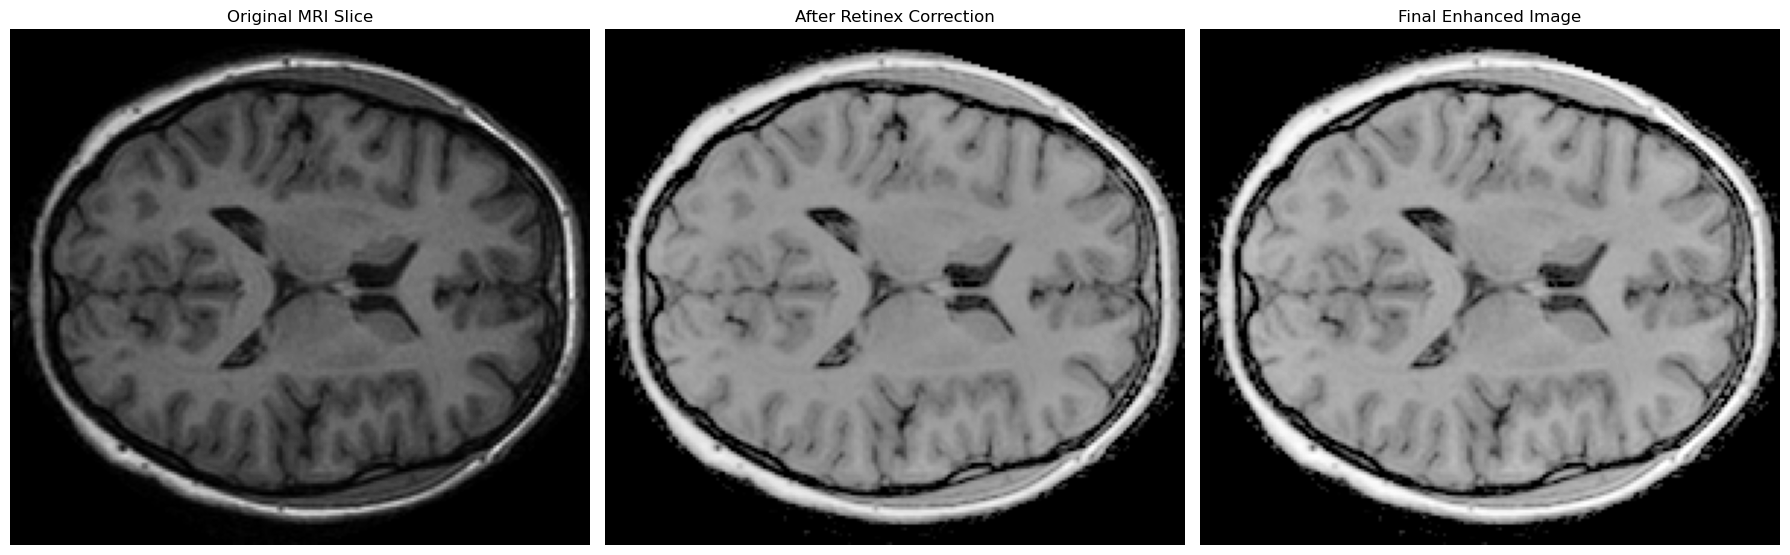

In [15]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import exposure

def single_scale_retinex(img, sigma=15):
    # Apply Single-Scale Retinex
    img = img.astype(np.float32) + 1e-6
    blur = cv2.GaussianBlur(img, (0, 0), sigma)
    retinex = np.log(img) - np.log(blur)
    retinex = np.clip(retinex, -2.0, 2.0)  # Clip extremes to reduce overshoot
    retinex = (retinex - np.min(retinex)) / (np.max(retinex) - np.min(retinex))
    return retinex

def dark_channel(im, size=15):
    # Compute dark channel
    b, g, r = cv2.split(im)
    min_img = cv2.min(cv2.min(r, g), b)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (size, size))
    dark_ch = cv2.erode(min_img, kernel)
    return dark_ch

def estimate_atmospheric_light(im, dark_ch, top_percent=0.001):
    flat_img = im.reshape(-1, 3)
    flat_dark = dark_ch.ravel()
    num_pixels = int(max(flat_dark.size * top_percent, 1))
    indices = np.argpartition(flat_dark, -num_pixels)[-num_pixels:]
    atmospheric_light = np.max(flat_img[indices], axis=0)
    return atmospheric_light

def transmission_estimate(im, atmospheric_light, omega=0.8, size=15):
    norm_img = im / atmospheric_light
    transmission = 1 - omega * dark_channel(norm_img, size)
    return transmission

def guided_filter(I, p, r, eps):
    mean_I = cv2.boxFilter(I, cv2.CV_64F, (r, r))
    mean_p = cv2.boxFilter(p, cv2.CV_64F, (r, r))
    corr_I = cv2.boxFilter(I * I, cv2.CV_64F, (r, r))
    corr_Ip = cv2.boxFilter(I * p, cv2.CV_64F, (r, r))
    var_I = corr_I - mean_I * mean_I
    cov_Ip = corr_Ip - mean_I * mean_p
    a = cov_Ip / (var_I + eps)
    b = mean_p - a * mean_I
    mean_a = cv2.boxFilter(a, cv2.CV_64F, (r, r))
    mean_b = cv2.boxFilter(b, cv2.CV_64F, (r, r))
    q = mean_a * I + mean_b
    return q

def recover_image(im, transmission, atmospheric_light, t0=0.2):
    transmission = np.clip(transmission, t0, 1)
    J = np.empty_like(im)
    for i in range(3):
        J[:, :, i] = (im[:, :, i] - atmospheric_light[i]) / transmission + atmospheric_light[i]
    J = np.clip(J, 0, 1)
    return J

def gamma_correction(image, gamma=0.8):
    return np.power(image, gamma)

# Load and normalize MRI NIfTI data
img = nib.load('t.nii')
data = np.squeeze(img.get_fdata())
print(f"Data shape: {data.shape}, Data type: {data.dtype}")

slice_index = data.shape[2] // 2
slice_img = data[:, :, slice_index]
slice_norm = (slice_img - np.min(slice_img)) / (np.max(slice_img) - np.min(slice_img))

# Convert grayscale to 3-channel for haze removal
slice_3ch = np.stack([slice_norm]*3, axis=-1).astype(np.float64)

# Step 1: Retinex
retinex_img = single_scale_retinex(slice_3ch, sigma=15)

# Step 2: Dark Channel
dark_ch = dark_channel(retinex_img, size=15)

# Step 3: Atmospheric Light
A = estimate_atmospheric_light(retinex_img, dark_ch)

# Step 4: Transmission Map
transmission = transmission_estimate(retinex_img, A, omega=0.8)

# Step 5: Refine transmission with guided filter
gray = cv2.cvtColor((retinex_img * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY).astype(np.float64) / 255
transmission_refined = guided_filter(gray, transmission, r=60, eps=1e-3)

# Step 6: Recover Image
dehazed_img = recover_image(retinex_img, transmission_refined, A)

# Step 7: Apply gamma correction to reduce overexposure
dehazed_img_gamma = gamma_correction(dehazed_img, gamma=0.8)

# Convert to grayscale for visualization
final_img = np.mean(dehazed_img_gamma, axis=2)
final_img = np.clip(final_img, 0, 1)

# Display original, intermediate, and final results
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
axs[0].imshow(slice_norm, cmap='gray')
axs[0].set_title('Original MRI Slice')
axs[0].axis('off')

axs[1].imshow(retinex_img[..., 0], cmap='gray')
axs[1].set_title('After Retinex Correction')
axs[1].axis('off')

axs[2].imshow(final_img, cmap='gray')
axs[2].set_title('Final Enhanced Image')
axs[2].axis('off')

plt.tight_layout()
plt.show()


# Sequence Decomposition Retinex Model and Haze Removal Algorithm [2]
Chen, Qihang, Zhidong Yuan, Chao Zhou, Weiguang Zhang, Mengxi Zhang, Yongfeng Yang, Dong Liang, et al. ‘Low-Dose Dental CT Image Enhancement Using a Multiscale Feature Sensing Network’. Nuclear Instruments and Methods in Physics Research Section A: Accelerators, Spectrometers, Detectors and Associated Equipment 981 (21 November 2020): 164530. https://doi.org/10.1016/j.nima.2020.164530.
